# Step 12: Update Model

In this step we test several different hypothesis to update the model

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: Reduce Threshold

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

df_combined["year"] = pd.to_datetime(df_combined["Date"], infer_datetime_format=True, dayfirst=False).dt.year

df_final = df_combined[df_combined["year"] >= 2021]

display(df_final["year"].value_counts())

df_train, df_test = train_test_split(df_final.drop(columns=["year"]), test_size=0.3, random_state=42)

2021    185059
2022      4000
Name: year, dtype: int64

# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,1.0,0.782609,0.666667,0.488212,0.552382,0.0,0.515787,0.519093
1,1.0,0.26087,0.666667,0.488212,0.552382,0.0,0.490178,0.51933
2,0.666667,0.73913,1.0,0.488212,0.506325,0.0,0.538316,0.664155
3,0.666667,0.347826,0.833333,0.488212,0.304678,0.0,0.223698,0.81245
4,0.333333,0.956522,0.666667,0.488212,0.552382,0.0,0.534688,0.653133
...,...,...,...,...,...,...,...,...
48155,0.0,1.0,0.0,0.488212,0.552382,0.0,0.484817,0.51823
48156,1.0,0.826087,0.5,0.537253,0.552382,1.0,0.433096,0.671368
48157,0.666667,0.652174,0.0,0.488212,0.552382,0.0,0.491603,0.51609
48158,0.666667,0.0,0.833333,0.488212,0.552382,0.0,0.271676,0.593182


# Predict

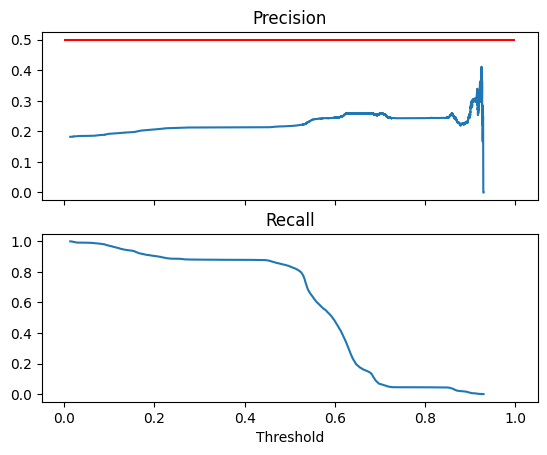

In [5]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_train = pipeline.predict_proba(X_train)
y_proba_test = pipeline.predict_proba(X_test)

df_test["probas"] = y_proba_test[:,1]

precision, recall, thresholds = precision_recall_curve(df_test['target'], df_test['probas'])


precision = precision[:-1]
recall = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

#min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
#print(min_index)

#print("Minimum threshold for precision: " + str(precision[min_index]))
#print("Minimum threshold for recall: " + str(recall[min_index]))

threshold = 0.4

y_pred_train = np.array([1 if p >= threshold else 0 for p in y_proba_train[:,1]])
y_pred_test = np.array([1 if p >= threshold else 0 for p in y_proba_test[:,1]])

# Evaluate

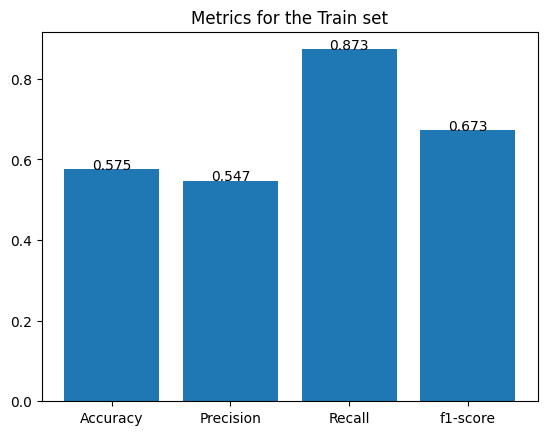

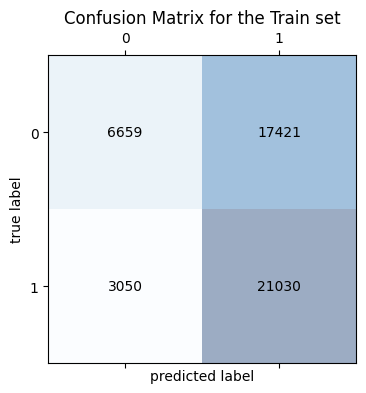

In [6]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

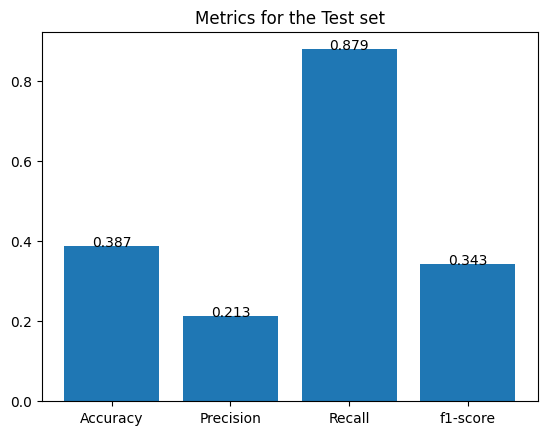

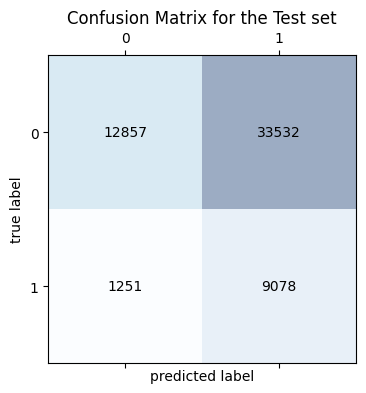

In [7]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

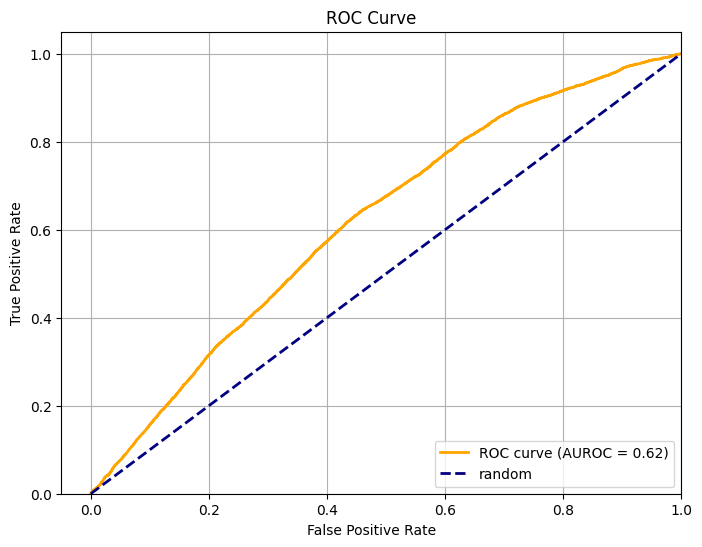

In [8]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8788846935811792)


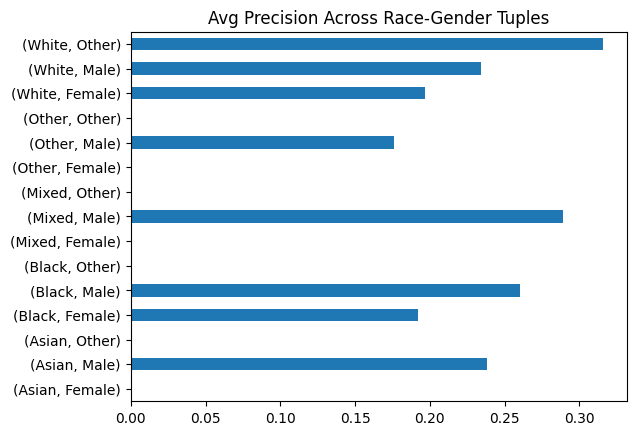

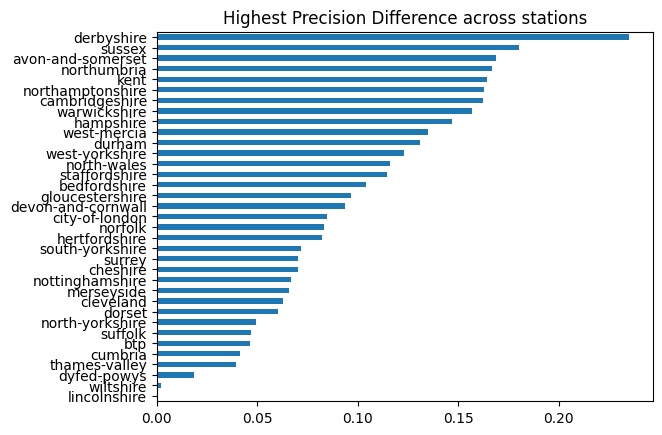

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2340205691514417, ('White', 'Female'): 0.19680642256018874, ('White', 'Other'): 0.3157894736842105, ('Black', 'Male'): 0.26041026656844973, ('Black', 'Female'): 0.19175627240143367, ('Black', 'Other'): nan, ('Other', 'Male'): 0.17604364430777764, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Asian', 'Male'): 0.23843964150655564, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.28898835202761, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan}
Num problematic departments: 27
Num good departments: 8
avg diff: 0.09768742857142858


In [9]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 2: Increase Threshold

# Get the data

In [10]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

# statios that have low number of outcomes
drop_stations = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_clean = aux_functions.clean_data(df_, drop_cols, drop_stations)
df_clean["is_new"] = False

df_new = pd.read_csv("data/requests1_final.csv")

df_new_clean = aux_functions.clean_new_data(df_new)
df_new_clean["is_new"] = True

df_combined = pd.concat([df_clean,df_new_clean], axis=0)

df_combined["year"] = pd.to_datetime(df_combined["Date"], infer_datetime_format=True, dayfirst=False).dt.year

df_final = df_combined[df_combined["year"] >= 2021]

display(df_final["year"].value_counts())

df_train, df_test = train_test_split(df_final.drop(columns=["year"]), test_size=0.3, random_state=42)


2021    185059
2022      4000
Name: year, dtype: int64

# Pipeline Definition

In [11]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler()),
            ('extra_imputer', SimpleImputer(strategy='mean')),    # in case station was not present in training set
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [12]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,1.0,0.782609,0.666667,0.488212,0.552382,0.0,0.515787,0.519093
1,1.0,0.26087,0.666667,0.488212,0.552382,0.0,0.490178,0.51933
2,0.666667,0.73913,1.0,0.488212,0.506325,0.0,0.538316,0.664155
3,0.666667,0.347826,0.833333,0.488212,0.304678,0.0,0.223698,0.81245
4,0.333333,0.956522,0.666667,0.488212,0.552382,0.0,0.534688,0.653133
...,...,...,...,...,...,...,...,...
48155,0.0,1.0,0.0,0.488212,0.552382,0.0,0.484817,0.51823
48156,1.0,0.826087,0.5,0.537253,0.552382,1.0,0.433096,0.671368
48157,0.666667,0.652174,0.0,0.488212,0.552382,0.0,0.491603,0.51609
48158,0.666667,0.0,0.833333,0.488212,0.552382,0.0,0.271676,0.593182


# Predict

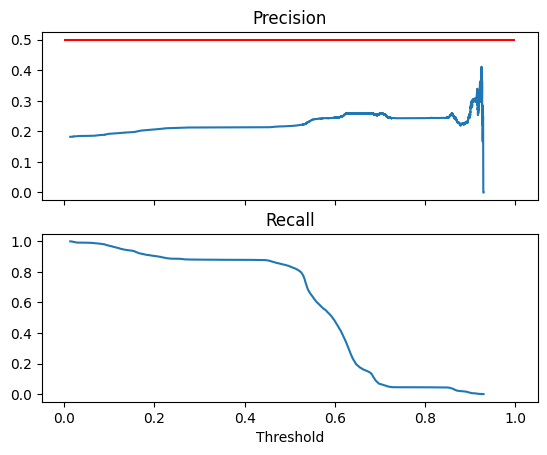

In [13]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_train = pipeline.predict_proba(X_train)
y_proba_test = pipeline.predict_proba(X_test)


df_test["probas"] = y_proba_test[:,1]

precision, recall, thresholds = precision_recall_curve(df_test['target'], df_test['probas'])


precision = precision[:-1]
recall = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

#min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
#print(min_index)

#print("Minimum threshold for precision: " + str(precision[min_index]))
#print("Minimum threshold for recall: " + str(recall[min_index]))

threshold = 0.6


y_pred_train = np.array([1 if p >= threshold else 0 for p in y_proba_train[:,1]])
y_pred_test = np.array([1 if p >= threshold else 0 for p in y_proba_test[:,1]])

# Evaluate

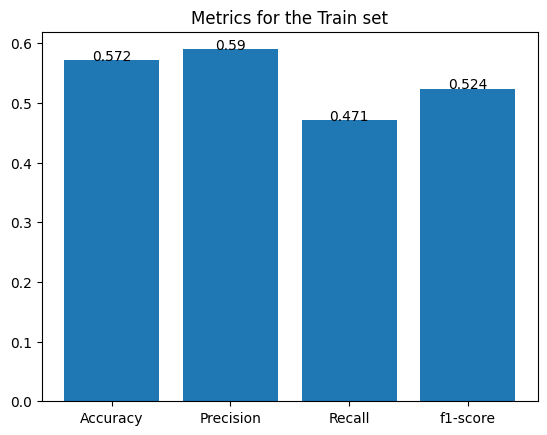

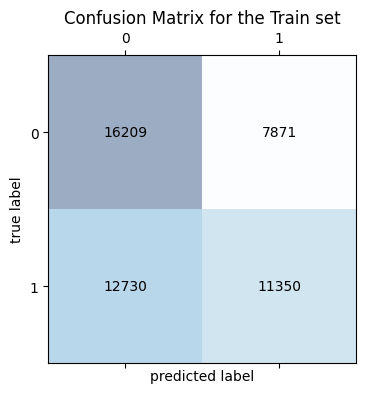

In [14]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

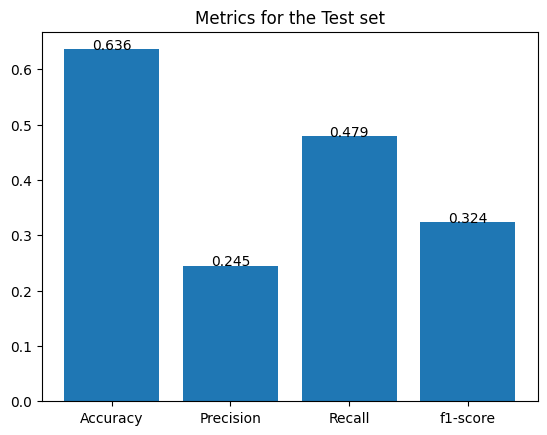

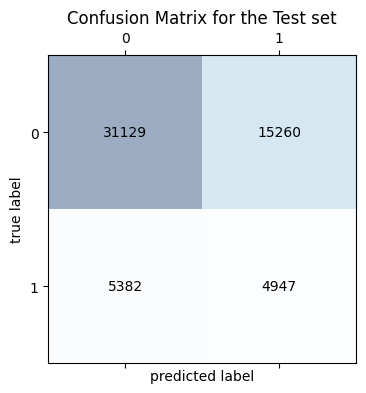

In [15]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

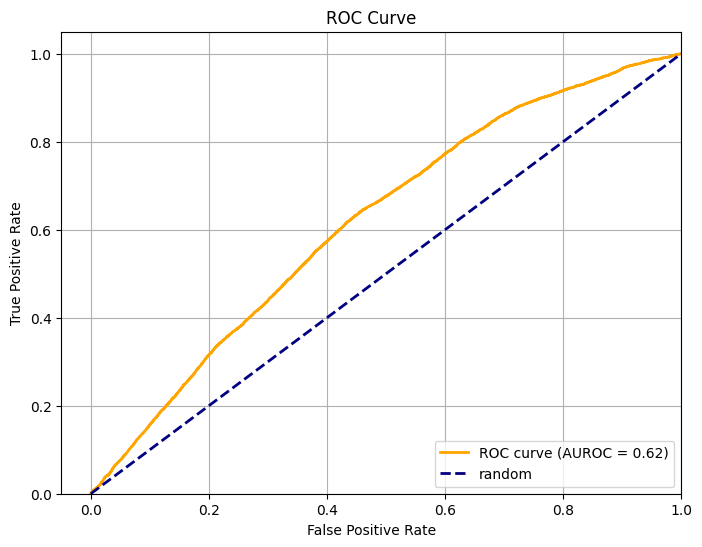

In [16]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.47894278245715943)


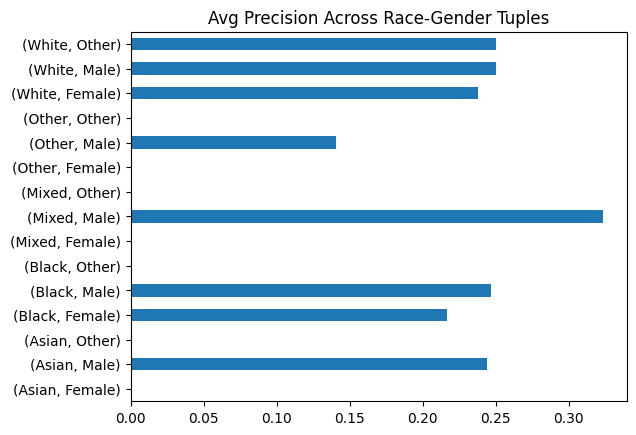

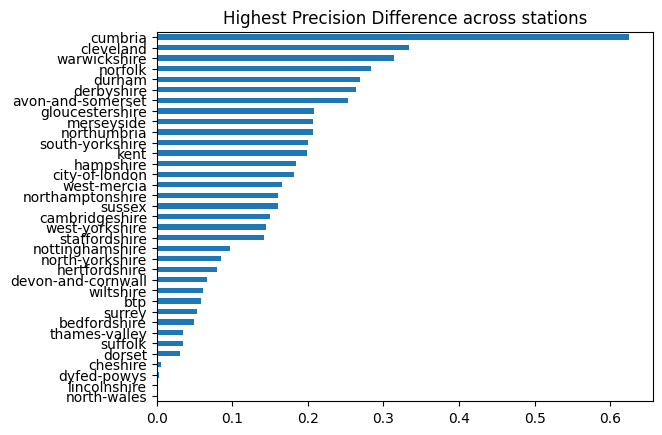

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.25018024150471596, ('White', 'Female'): 0.2380730801382985, ('White', 'Other'): 0.25, ('Black', 'Male'): 0.24698636828764897, ('Black', 'Female'): 0.21637426900584794, ('Black', 'Other'): nan, ('Other', 'Male'): 0.14088439813978787, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Asian', 'Male'): 0.24420569389812907, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.32366946778711486, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan}
Num problematic departments: 27
Num good departments: 8
avg diff: 0.1516182857142857


In [17]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")